In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.optimize import curve_fit

In [2]:
# from fair import *
# from fair.scripts.data_retrieval import *

## Define Functions

In [3]:
## calculate cost of perturbation due to carbon
## input: temperature profile, perturbed temperature profile, total consumption, and discount function

def cost_of_perturbation(W, W_prime, discount_function, gamma=2, D0=0.00267):
#     S_Wt = D0*T**gamma
#     S_Wt_perturb = D0*T_perturb**gamma
#     consumption_loss_fraction = S_Wt_perturb-S_Wt
#     absolute_consumption_loss = consumption_loss_fraction*W
#     discounted_consumption_loss = absolute_consumption_loss*discount_function
#     area = simps(discounted_consumption_loss, dx=1)
#     cost = area*10**12  # convert to dollar amount
    absolute_consumption_loss = W-W_prime
    discounted_consumption_loss = absolute_consumption_loss*discount_function
    area = simps(discounted_consumption_loss, dx=1)
    cost = area*10**12  # convert to dollar amount
    
    return cost

In [4]:
## calculate abatement given a carbon price

# def abatement(P, P0, P_h=44, r=20, s=18, Am=1.1):
#     A = Am/(1+((P-P0)/P_h)**(-r/s))
    
#     return A

# P_100 = 500

# def abatement(P, P0, r=0.04, P_h=100, s=0.05, P_100=P_100):
#     if P0 >= P_h:
#         print("P0 is greater than P_h")

#     Am = 1+((P_100-P0)/(P_h-P0))**(-s/r)
#     A = Am/(1+((P-P0)/(P_h-P0))**(-s/r))
        
#     return A

P_50 = 200  # 187.5 * 0.7625000000000001
P_100 = 400  # 187.5
s = 0.05
r = 0.04

# P_50=100, s=0.05, r=0.04, P_100=500

def abatement(P, P0, P_50=P_50, r=r, s=s, P_100=P_100):  # 0.05
    if P0 >= P_50:
        print("P0 is greater than P_50")
    elif ((P_100-P0)/(P_50-P0))**(s/r) <= 2:
        print("MAC curve condition not satisfied")
    
    P_h = P0 + ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)
    Am = 1 + ((P_100 - P0) / (P_h - P0)) ** (-s / r)
    
    A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
    
    return A

In [5]:
# ## Nick's function to get SSP emissions data (use to get historical data to 2019)

# def get_ssp_emissions(ssp, end_year = 2019):
    
#     emms = RCMIP_to_FaIR_input_emms(ssp).interpolate().loc[1750:end_year]

#     ## rebase emission-driven forcings & species with natural emissions included in RCMIP to zero @ 1750
#     rebase_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi','methyl_bromide','methyl_chloride','chcl3','ch2cl2']
#     emms.loc[:,rebase_species] -= emms.loc[1750,rebase_species]
    
#     return emms

In [6]:
## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

# Steps outlined in Email

## 1. Create Unperturbed Temperature Profile

In [7]:
# get historical data (taken from chrisroadmap)

T_gas_df = pd.read_csv("T_gas.csv", index_col=0)

T_2019 = T_gas_df['CO2_best'][2019]

In [8]:
start_year = 1750
last_historical_year = 2019
end_year = 3000

years = np.arange(start_year, end_year+1)
T_forecast_years = np.arange(last_historical_year, end_year+1)
T_forecast_length = end_year - last_historical_year + 1

In [9]:
delta_T = 2
alpha = 0.02
T_forecast = T_2019 + delta_T * (1 - np.exp(-alpha*np.arange(T_forecast_length)))

In [10]:
T = np.concatenate([T_gas_df['CO2_best'],T_forecast[1:]])

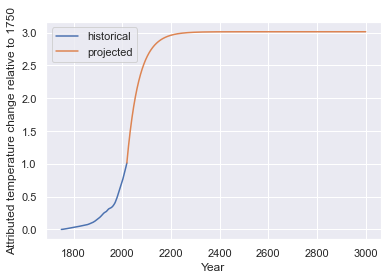

In [11]:
plt.plot(T_gas_df['CO2_best'], label="historical")
plt.plot(T_forecast_years, T_forecast, label="projected")
plt.xlabel("Year")
plt.ylabel("Attributed temperature change relative to 1750")
plt.legend()

## Total Consumption

In [12]:
# consumption_growth = 0.02
# W0 = 80

# W = []

# # for i in range(len(years)):
# #     W.append(W0*consumption_growth**(i-(last_historical_year - start_year)))
    
# for i in range(len(years)):
#     W.append(W0*np.exp(consumption_growth*(i-(last_historical_year - start_year))))

# W = np.asarray(W)

In [13]:
# plt.plot(years, W)
# plt.xlabel("Year")
# plt.ylabel("Absolute Consumption ($trillion/year)")
# plt.xlim(2000, 2100)
# plt.ylim(0, 400)

alternative functional form for above for the fast transition

## 2. Calculate SCC as a function of time for a range of years

In [14]:
def create_W(W_2019, last_historical_year, start_year, T_forecast_years, g):
    W = []
    W_historical = [W_2019] * (last_historical_year - start_year + 1)
    W_forecast = []
    W_previous_year = W_historical[-1]

    for i in range(len(T_forecast_years) - 1):
        W_this_year = W_previous_year*np.exp(g[i])
        W_forecast.append(W_this_year)
        W_previous_year = W_this_year

    W = W_historical + W_forecast

    W = np.asarray(W)
    return W

In [15]:
# def cost_of_perturbation_g():
#     absolute_consumption_loss = W-W_prime
#     discounted_consumption_loss = absolute_consumption_loss*discount_function
#     area = simps(discounted_consumption_loss, dx=1)
#     cost = area*10**12  # convert to dollar amount
#     SCC = cost/(10**9)

In [16]:
## years to calculate SCC
first_perturbed_year = last_historical_year
last_perturbed_year = 2500
year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

consumption_growth = 0.02
W_2019 = 80
consumption_discount = 0.035
# consumption_discount = consumption_growth + 0.015

g_2019 = 0.02
# g_grad = 0.0001  # 0.00034
g_grad = 0.0004

SCC_list = []

for j in range(len(year_of_perturbation)):
    ## define perturbed temperature profile for a given year
    T_TCRE = 0.00054  # need to check this for FAIR!
    k_s = 0.12

    T_p = np.zeros(T_forecast_length)
    for i in range(len(T_forecast_years)):
        if year_of_perturbation[j] <= T_forecast_years[i]:
            T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))
    T_forecast_perturbed = T_forecast+T_p
    T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])
    

    g = g_2019 - g_grad*(T_forecast[:-1]-T_2019)**2
    g_prime = g_2019 - g_grad*(T_forecast_perturbed[:-1]-T_2019)**2
    
#     W = []
#     W_historical = [W_2019] * (last_historical_year - start_year + 1)
#     W_forecast = []
#     W_previous_year = W_historical[-1]

#     for i in range(len(T_forecast_years) - 1):
#         W_this_year = W_previous_year*np.exp(g[i])
#         W_forecast.append(W_this_year)
#         W_previous_year = W_this_year

#     W = W_historical + W_forecast

#     W = np.asarray(W)
    W = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g)
    
    
#     W_prime = []
#     W_historical = [W_2019] * (last_historical_year - start_year + 1)
#     W_forecast = []
#     W_previous_year = W_historical[-1]

#     for i in range(len(T_forecast_years) - 1):
#         W_this_year = W_previous_year*np.exp(g_prime[i])
#         W_forecast.append(W_this_year)
#         W_previous_year = W_this_year

#     W_prime = W_historical + W_forecast

#     W_prime = np.asarray(W_prime)
    
    W_prime = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g_prime)

    ## define discount function
    num_of_years = len(years)
    discount_function = np.zeros(num_of_years)

    for i in range(num_of_years):
        if years[i] >= year_of_perturbation[j]:
            discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
    
    ## calculate SCC
#     cost = cost_of_perturbation(T=T, T_perturb=T_perturbed, W=W, discount_function=discount_function)
#     SCC = cost/(10**9)
#     absolute_consumption_loss = W-W_prime
#     discounted_consumption_loss = absolute_consumption_loss*discount_function
#     area = simps(discounted_consumption_loss, dx=1)
#     cost = area*10**12  # convert to dollar amount
    cost = cost_of_perturbation(W, W_prime, discount_function, gamma=2, D0=0.00267)
    SCC = cost/(10**9)
    
    if j == 0:
        print(T_forecast_perturbed)
#         plt.plot(T_forecast[:-1], g)
#         plt.plot(years, discounted_consumption_loss)
    
    if SCC < P_100:
        SCC_list.append(SCC)
    else:
        SCC_list.append(P_100)
        break

[1.01369292 1.05335663 1.09222926 1.1303271  1.16766608 1.20426172
 1.2401292  1.27528332 1.30973858 1.34350911 1.37660876 1.40905107
 1.44084925 1.47201627 1.50256479 1.53250721 1.56185567 1.59062205
 1.61881799 1.64645486 1.67354384 1.70009583 1.72612154 1.75163145
 1.77663582 1.80114471 1.82516797 1.84871526 1.87179603 1.89441955
 1.91659489 1.93833095 1.95963646 1.98051995 2.0009898  2.02105421
 2.04072122 2.05999871 2.07889441 2.09741588 2.11557054 2.13336567
 2.15080837 2.16790565 2.18466434 2.20109116 2.21719267 2.23297533
 2.24844544 2.26360921 2.27847269 2.29304185 2.3073225  2.32132036
 2.33504104 2.34849001 2.36167267 2.37459429 2.38726004 2.39967498
 2.41184409 2.42377222 2.43546416 2.44692458 2.45815807 2.46916911
 2.47996212 2.4905414  2.50091121 2.51107567 2.52103887 2.53080477
 2.5403773  2.54976028 2.55895746 2.56797253 2.57680908 2.58547066
 2.59396073 2.60228268 2.61043984 2.61843549 2.6262728  2.63395493
 2.64148494 2.64886585 2.6561006  2.6631921  2.67014317 2.6769

In [17]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

In [18]:
SCC_array

array([146.31096293, 150.97495695, 155.72507863, 160.56280798,
       165.48988345, 170.50772851, 175.61825896, 180.82283932,
       186.12356987, 191.52175373, 197.01968304, 202.61859689,
       208.320987  , 214.12802573, 220.04241228, 226.06524947,
       232.19945224, 238.44605092, 244.80818471, 251.28680844,
       257.88529439, 264.60451874, 271.44809596, 278.41682034,
       285.51455806, 292.74201806, 300.10332803, 307.59910814,
       315.2337577 , 323.00780446, 330.9259299 , 338.98856559,
       347.20068607, 355.56262285, 364.07965483, 372.75200938,
       381.58528151, 390.5795903 , 399.74085893, 400.        ])

Text(0, 0.5, 'SCC ($)')

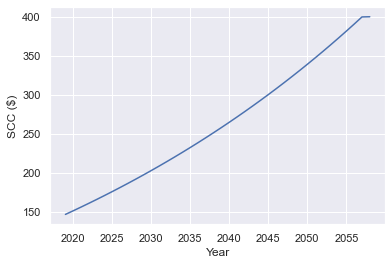

In [19]:
plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

### Check 100% abatement has been achieved!

In [20]:
if SCC_array[-1] < P_100:
    print("P_100 not achieved by achieved by final perturbed year")

### Fit SCC line to forecast

In [21]:
# plt.plot(year_of_perturbation, SCC_array)
# plt.xlabel("Year")
# plt.ylabel("SCC ($)")
# plt.yscale("log")

In [22]:
# log_SCC = np.log(SCC_array)

In [23]:
# ## add linear fit
# X = sm.add_constant(year_of_perturbation) # add a constant to fit
# results = sm.OLS(log_SCC, X).fit() # save results of fit

In [24]:
# #Plot with Fit & Summary 
# plt.plot(year_of_perturbation, log_SCC)
# plt.plot(year_of_perturbation, results.params[0]+results.params[1]*year_of_perturbation, 'r' , label='fitted_line')
# plt.xlabel("Year")
# plt.ylabel("ln(SCC)")

In [25]:
# SCC_forecasted = np.exp(results.params[0]+results.params[1]*T_forecast_years)

In [26]:
T_forecast_length

982

In [27]:
SCC_forecasted = []

for i in range(T_forecast_length):
    if i < len(SCC_array):
        SCC_forecasted.append(SCC_array[i])
    else:
#         SCC_forecasted.append(SCC_array[-1])
        SCC_forecasted.append(P_100)

SCC_forecasted = np.array(SCC_forecasted)

In [28]:
SCC_forecasted

array([146.31096293, 150.97495695, 155.72507863, 160.56280798,
       165.48988345, 170.50772851, 175.61825896, 180.82283932,
       186.12356987, 191.52175373, 197.01968304, 202.61859689,
       208.320987  , 214.12802573, 220.04241228, 226.06524947,
       232.19945224, 238.44605092, 244.80818471, 251.28680844,
       257.88529439, 264.60451874, 271.44809596, 278.41682034,
       285.51455806, 292.74201806, 300.10332803, 307.59910814,
       315.2337577 , 323.00780446, 330.9259299 , 338.98856559,
       347.20068607, 355.56262285, 364.07965483, 372.75200938,
       381.58528151, 390.5795903 , 399.74085893, 400.        ,
       400.        , 400.        , 400.        , 400.        ,
       400.        , 400.        , 400.        , 400.        ,
       400.        , 400.        , 400.        , 400.        ,
       400.        , 400.        , 400.        , 400.        ,
       400.        , 400.        , 400.        , 400.        ,
       400.        , 400.        , 400.        , 400.  

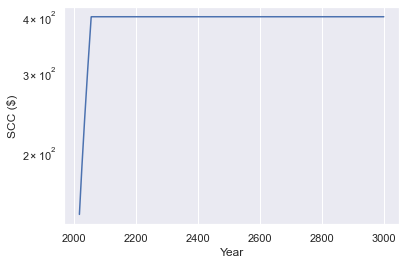

In [29]:
plt.plot(T_forecast_years, SCC_forecasted)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

## 3. Abatement as a function of time

In [30]:
P0 = SCC_forecasted[0]

In [31]:
forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)  # , r=consumption_discount

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_7061/2392669901.py:35: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


problems with certain values due to constraints of the model

In [32]:
((P_100-P0)/(P_50-P0))**(s/0.04)

6.966587664308996

In [33]:
SCC_forecasted

array([146.31096293, 150.97495695, 155.72507863, 160.56280798,
       165.48988345, 170.50772851, 175.61825896, 180.82283932,
       186.12356987, 191.52175373, 197.01968304, 202.61859689,
       208.320987  , 214.12802573, 220.04241228, 226.06524947,
       232.19945224, 238.44605092, 244.80818471, 251.28680844,
       257.88529439, 264.60451874, 271.44809596, 278.41682034,
       285.51455806, 292.74201806, 300.10332803, 307.59910814,
       315.2337577 , 323.00780446, 330.9259299 , 338.98856559,
       347.20068607, 355.56262285, 364.07965483, 372.75200938,
       381.58528151, 390.5795903 , 399.74085893, 400.        ,
       400.        , 400.        , 400.        , 400.        ,
       400.        , 400.        , 400.        , 400.        ,
       400.        , 400.        , 400.        , 400.        ,
       400.        , 400.        , 400.        , 400.        ,
       400.        , 400.        , 400.        , 400.        ,
       400.        , 400.        , 400.        , 400.  

In [34]:
forecasted_abatement

array([0.        , 0.03907819, 0.08990649, 0.1436718 , 0.19761819,
       0.25035387, 0.30112643, 0.34953158, 0.39538519, 0.43862862,
       0.47929431, 0.51745775, 0.55323346, 0.58674376, 0.61812735,
       0.64751538, 0.6750455 , 0.70084152, 0.72502979, 0.74772075,
       0.76902609, 0.78904152, 0.80786386, 0.82557482, 0.84225752,
       0.8579811 , 0.87281661, 0.88682235, 0.90005899, 0.91257561,
       0.92442403, 0.9356456 , 0.9462847 , 0.9563762 , 0.96595818,
       0.97506012, 0.98371482, 0.99194726, 0.9997858 , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [35]:
# abatement(P=np.array([50]), P0=P0, r=consumption_discount, P_100=200)

In [36]:
# P0

In [37]:
# r=0.04
# s=0.029687500000000006
# (P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)

In [38]:
# ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)

In [39]:
T_forecast_years[last_perturbed_year - 2019]

2500

In [40]:
forecasted_abatement[last_perturbed_year - 2019]

1.0

Text(0, 0.5, 'Abatement')

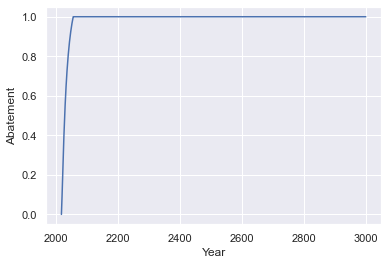

In [41]:
plt.plot(T_forecast_years, forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

In [42]:
# # choose ssp to use
# ssp='ssp245'

# # get emissions data using imported scripts + convert into FaIRv2.0.0-alpha multiindex format
# ssp_emms = pd.concat([get_ssp_emissions(ssp)],axis=1,keys=[ssp])

In [43]:
# ssp_emms["ssp245"].to_csv("ssp245.csv")

In [44]:
ssp_df = pd.read_csv("ssp245.csv", index_col=0)

In [45]:
# ssp245_CO2_past = ssp_emms["ssp245"]["carbon_dioxide"]*(44/12)  

In [46]:
ssp245_CO2_past = ssp_df["carbon_dioxide"]*(44/12)  

In [47]:
CO2_baseline = ssp245_CO2_past[2019] # set baseline to current emissions

In [48]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

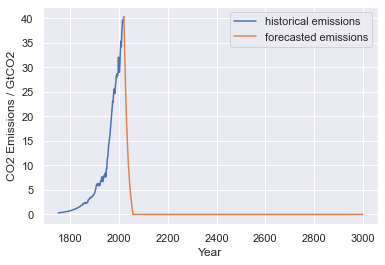

In [49]:
plt.plot(ssp245_CO2_past, label="historical emissions")
plt.plot(T_forecast_years, forecasted_emissions, label="forecasted emissions")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions / GtCO2")
plt.legend()

## 5. Cumulative Emissions to Temperature Change

In [50]:
cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

In [51]:
# cumulative_emissions

In [52]:
# len(cumulative_emissions)

In [53]:
# cumulative_emissions = []

# for i in range(len(T_forecast_years)):
#     area = simps(forecasted_emissions[:i+1], dx=1)
#     cumulative_emissions.append(area)

In [54]:
# cumulative_emissions_array = np.asarray(cumulative_emissions)

In [55]:
temperature_change = T_TCRE*cumulative_emissions_array

In [56]:
# temperature_change_plateau = np.array(temperature_change, copy=True)

# for i in range(len(temperature_change_plateau)):
#     if i > np.argmax(temperature_change_plateau):
#         temperature_change_plateau[i] = max(temperature_change_plateau)

In [57]:
max(temperature_change)

0.2919062519029056

In [58]:
T_forecast_iteration0 = T_2019 + temperature_change
# T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

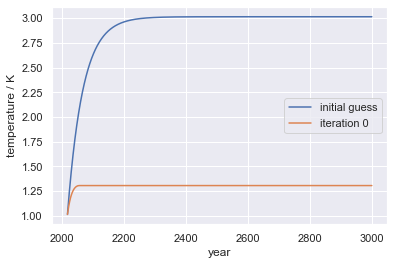

In [59]:
plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_iteration0, label="iteration 0")
# plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("year")
plt.ylabel("temperature / K")
plt.legend()

# Iterating Further

In [60]:
# T_forecast_first_loop = T_forecast_iteration0_plateau
# T_forecast_iteration = T_forecast_iteration0_plateau

In [61]:
T_forecast_first_loop = T_forecast_iteration0
T_forecast_iteration = T_forecast_iteration0

In [62]:
# T_forecast_iteration

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_7061/2392669901.py:35: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_7061/2392669901.py:35: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_7061/2392669901.py:35: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_7061/2392669901.py:35: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_7061/2392669901.py:35: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_7061/2

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_7061/2392669901.py:35: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_7061/2392669901.py:35: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_7061/2392669901.py:35: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_7061/2392669901.py:35: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


convergence condition not achieved


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_7061/2392669901.py:35: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


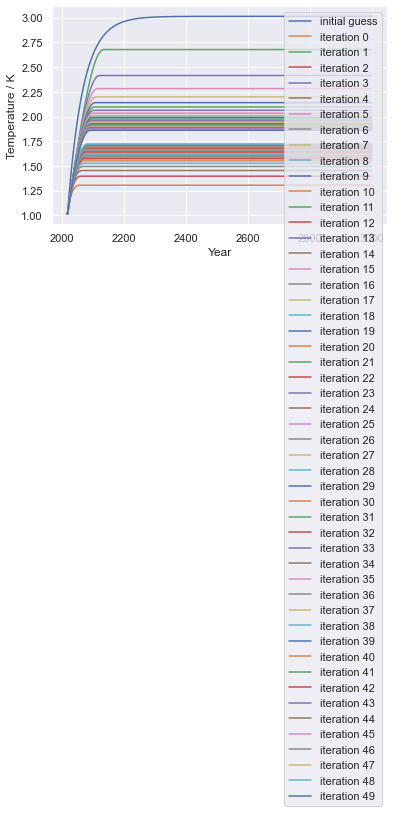

In [63]:
num_of_iterations = 49

first_perturbed_year = last_historical_year

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_first_loop, label="iteration 0")

for k in range(num_of_iterations):
    T_iteration = np.concatenate([T_gas_df['CO2_best'],T_forecast_iteration[1:]])

    SCC_list = []

    for j in range(len(year_of_perturbation)):
        ## define perturbation
        T_TCRE = 0.00054  # need to check this! *100 for 100GtCO2 added
        k_s = 0.12

        T_p = np.zeros(T_forecast_length)

        for i in range(len(T_forecast_years)):
            if year_of_perturbation[j] <= T_forecast_years[i]:
                T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))

        T_forecast_perturbed = T_forecast_iteration+T_p

        T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])
        
#         g_2019 = 0.02
#         g_grad = 0.00034

        g = g_2019 - g_grad*(T_forecast_iteration[:-1]-T_2019)**2
        g_prime = g_2019 - g_grad*(T_forecast_perturbed[:-1]-T_2019)**2
        
        
        W = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g)
        W_prime = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g_prime)

        ## define discount function
        num_of_years = len(years)

#         consumption_discount = 0.035
        discount_function = np.zeros(num_of_years)

        for i in range(num_of_years):
            if years[i] >= year_of_perturbation[j]:
                discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
#         cost = cost_of_perturbation(T=T_iteration, T_perturb=T_perturbed, W=W, discount_function=discount_function)
#         cost = cost_of_perturbation(W, W_prime, discount_function, gamma=2, D0=0.00267)
        absolute_consumption_loss = W-W_prime
        discounted_consumption_loss = absolute_consumption_loss*discount_function
        area = simps(discounted_consumption_loss, dx=1)
        cost = area*10**12  # convert to dollar amount
        
        SCC = cost/(10**9)
    
#         if j == 0:
# #             plt.plot(T_forecast[:-1], g)
# #             plt.plot(years, discounted_consumption_loss)
#             print(W)
# #             print(g_prime[1])
# #             print(T_forecast_perturbed)
#             print(W_prime)
#             print(W-W_prime)
#             print(T_p)
#             print(T_forecast_perturbed-T_forecast_iteration)
    
        
        if SCC < P_100:
            SCC_list.append(SCC)
        else:
            SCC_list.append(P_100)
            break

    SCC_array = np.asarray(SCC_list)
#     log_SCC = np.log(SCC_array)

#     ## add linear fit
#     X = sm.add_constant(year_of_perturbation) # add a constant to fit
#     results = sm.OLS(log_SCC, X).fit() # save results of fit

#     SCC_forecasted = np.exp(results.params[0]+results.params[1]*T_forecast_years)
    SCC_forecasted = []

    for i in range(T_forecast_length):
        if i < len(SCC_array):
            SCC_forecasted.append(SCC_array[i])
        else:
#             SCC_forecasted.append(SCC_array[-1])
            SCC_forecasted.append(P_100)

    SCC_forecasted = np.array(SCC_forecasted)

    P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)  # , r=consumption_discount
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

#     cumulative_emissions = []

#     for i in range(len(T_forecast_years)):
#         area = simps(forecasted_emissions[:i+1], dx=1)
#         cumulative_emissions.append(area)

#     cumulative_emissions_array = np.asarray(cumulative_emissions)

    cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

    temperature_change = T_TCRE*cumulative_emissions_array
    
    # to return to the previous method remove for loop and T_forecast_iteration = T_2019 + temperature_change
#     temperature_change_plateau = np.array(temperature_change, copy=True)
#     for i in range(len(temperature_change_plateau)):
#         if i > np.argmax(temperature_change_plateau):
#             temperature_change_plateau[i] = max(temperature_change_plateau)

#     T_forecast_iteration = T_2019 + temperature_change_plateau
    
    T_forecast_iteration = T_2019 + temperature_change
    
    plt.plot(T_forecast_years, T_forecast_iteration, label="iteration "+str(k+1))
    
    if k == 0:
        peak_T = max(T_forecast_iteration)
#         print(f"{g_prime = }")
    else:
        previous_peak_T = peak_T
        peak_T = max(T_forecast_iteration)
        if abs(peak_T - previous_peak_T) < 0.005:
            print(k)
            break
    
    if k == num_of_iterations - 1:
        print("convergence condition not achieved")

plt.xlabel("Year")
plt.ylabel("Temperature / K")
plt.legend()

In [64]:
SCC_forecasted[0]

76.31329151859799

In [65]:
# SCC_forecasted[2040-2019]

***this is fairly analogous to the Newton-Raphson Method***
- the initial temperature profile is essentially just a starting guess; getting pushed toward temperature profile solution
- could stop the iterations when the difference between two consecutive lines is small

In [66]:
((P_100-P0)/(P_50-P0))**(s/r)

3.3285285969997833

In [67]:
P0

76.31329151859799

In [68]:
## peak Temperature
max(T_forecast_iteration)

1.861561414749053

under default settings: 2.0439370757585076

In [69]:
SCC_forecasted[0]

76.31329151859799